In [1]:
import sys, os

In [2]:
# run_path = "/home/harishbabu/projects/PIPNet/runs/154-PruningNaiveHPIPNet_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/158-PruningNaiveHPIPNetExpWeightPruning_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/159-PruningNaiveHPIPNetMaskL1=1.0_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/160-PruningNaiveHPIPNetMaskL1=0.5_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/161-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15eps_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

run_path = "/projects/ml4science/harishbabu/projects/PIPNet/162-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/163-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.2MinCont=0.1_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/projects/ml4science/harishbabu/projects/PIPNet/164-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.05MinCont=0.1_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/167-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.05MinCont=0.1_cnext26_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/178-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.05MinCont=0.1_cnext26_CUB-190-imgnet-224_WeightedCE_with-equalize-aug_img=224_nprotos=20"

try:
    sys.path.remove('/home/harishbabu/projects/PIPNet')
except:
    pass
sys.path.insert(0, os.path.join(run_path, 'source_clone'))


In [3]:
print(run_path)

/projects/ml4science/harishbabu/projects/PIPNet/162-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20


In [4]:
import torch.nn as nn
import torch

import sys, os
import random
import numpy as np
from shutil import copy
import matplotlib.pyplot as plt
from copy import deepcopy

from omegaconf import OmegaConf
import shutil
import pickle
import random
from tqdm import tqdm

from torchvision.datasets.folder import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
# from skimage.filters import threshold_local, gaussian
import ntpath

In [5]:
print(sys.path[0])

/projects/ml4science/harishbabu/projects/PIPNet/162-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20/source_clone


In [6]:
# import pipnet.pipnet
# from pipnet.pipnet import PIPNet, get_network
# # from pipnet import pipnet
# print(pipnet.__file__)
from util import node
print(node.__file__)

/projects/ml4science/harishbabu/projects/PIPNet/162-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20/source_clone/util/node.py


In [7]:
from pipnet.pipnet import PIPNet, get_network
from util.log import Log
from util.args import get_args, save_args, get_optimizer_nn
from util.data import get_dataloaders
from util.func import init_weights_xavier
from pipnet.train import train_pipnet, test_pipnet
# from pipnet.test import eval_pipnet, get_thresholds, eval_ood
from util.eval_cub_csv import eval_prototypes_cub_parts_csv, get_topk_cub, get_proto_patches_cub
from util.vis_pipnet import visualize, visualize_topk
from util.visualize_prediction import vis_pred, vis_pred_experiments
from util.node import Node
from util.phylo_utils import construct_phylo_tree, construct_discretized_phylo_tree
from util.func import get_patch_size
from util.data import ModifiedLabelLoader

Heatmaps showing where a prototype is found will not be generated because OpenCV is not installed.


In [8]:
from PIL import Image
import numpy as np
import pdb

def get_heatmap(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)


def get_heatmap_uninterpolated(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1]), \
                                                                                          resample=Image.NEAREST ))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def get_bb_gaussian_threshold(latent_activation, sigma=1.0, percentile=97, extend_h=0, extend_w=0):
    # latent_activation -> []
    upscaled_similarity = get_upscaled_activation_uninterpolated(latent_activation, \
                                                                 image_size=(args.image_size, args.image_size))
    upscaled_similarity = minmaxscale(upscaled_similarity)
    upscaled_similarity = gaussian(upscaled_similarity, sigma=sigma)
    upscaled_similarity = threshold_local(upscaled_similarity, block_size=15, method='mean')
    h_min, h_max, w_min, w_max = find_top_percentile_bbox(upscaled_similarity ,percentile=97)
    h_min = max(0, h_min-extend_h)
    h_max = min(upscaled_similarity.shape[0], h_max+extend_h)
    w_min = max(0, w_min-extend_w)
    w_max = min(upscaled_similarity.shape[1], w_max+extend_w)
    return h_min, h_max, w_min, w_max


def minmaxscale(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())

from torch.utils.data import DataLoader, SequentialSampler
from torch.utils.data import DataLoader

def unshuffle_dataloader(dataloader):
    if type(dataloader.dataset) == ImageFolder:
        dataset = dataloader.dataset
    else:
        dataset = dataloader.dataset.dataset.dataset
    new_dataloader = DataLoader(
        dataset=dataset,
        batch_size=dataloader.batch_size,
        shuffle=False,
        num_workers=dataloader.num_workers,
        pin_memory=dataloader.pin_memory,
        drop_last=dataloader.drop_last,
        timeout=dataloader.timeout,
        worker_init_fn=dataloader.worker_init_fn,
        multiprocessing_context=dataloader.multiprocessing_context,
        generator=dataloader.generator,
        prefetch_factor=dataloader.prefetch_factor,
        persistent_workers=dataloader.persistent_workers
    )
    return new_dataloader

## Load Model

In [9]:
args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

if args.phylo_config:
    phylo_config = OmegaConf.load(args.phylo_config)

if args.phylo_config:
    # construct the phylo tree
    if phylo_config.phyloDistances_string == 'None':
        if '031' in run_path: # this run uses a different phylogeny file that had an extra root node which is a mistake
            root = construct_phylo_tree('/home/harishbabu/data/phlyogenyCUB/18Species-with-extra-root-node/1_tree-consensus-Hacket-18Species-modified_cub-names_v1.phy')
        else:
            root = construct_phylo_tree(phylo_config.phylogeny_path)
        print('-'*25 + ' No discretization ' + '-'*25)
    else:
        root = construct_discretized_phylo_tree(phylo_config.phylogeny_path, phylo_config.phyloDistances_string)
        print('-'*25 + ' Discretized ' + '-'*25)
else:
    # construct the tree (original hierarchy as described in the paper)
    root = Node("root")
    root.add_children(['animal','vehicle','everyday_object','weapon','scuba_diver'])
    root.add_children_to('animal',['non_primate','primate'])
    root.add_children_to('non_primate',['African_elephant','giant_panda','lion'])
    root.add_children_to('primate',['capuchin','gibbon','orangutan'])
    root.add_children_to('vehicle',['ambulance','pickup','sports_car'])
    root.add_children_to('everyday_object',['laptop','sandal','wine_bottle'])
    root.add_children_to('weapon',['assault_rifle','rifle'])
    # flat root
    # root.add_children(['scuba_diver','African_elephant','giant_panda','lion','capuchin','gibbon','orangutan','ambulance','pickup','sports_car','laptop','sandal','wine_bottle','assault_rifle','rifle'])
root.assign_all_descendents()

exp_no = int(os.path.basename(run_path)[:3])

if exp_no < 77:
    if ('num_protos_per_descendant' in args) and (args.num_protos_per_descendant > 0):
        for node in root.nodes_with_children():
            node.set_num_protos(args.num_protos_per_descendant)
if exp_no == 77:
    # update num of protos per node based on num_protos_per_descendant
    if args.num_features == 0 and args.num_protos_per_descendant == 0:
        raise Exception('Either of num_features or num_protos_per_descendant must be greater than zero')
    for node in root.nodes_with_children():
        node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                                                            min_protos=args.num_features)
else:
    if ('num_protos_per_descendant' in args):
        # update num of protos per node based on num_protos_per_descendant
        if args.num_features == 0 and args.num_protos_per_descendant == 0:
            raise Exception('Either of num_features or num_protos_per_descendant must be greater than zero')
        for node in root.nodes_with_children():
            node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                                min_protos=args.num_features,\
                                split_protos=('protopool' in args) and (args.protopool == 'n'))

------------------------- No discretization -------------------------


In [10]:
!which python

/home/harishbabu/.conda/envs/hpnet4/bin/python


In [11]:
args.batch_size = 1

print(args.batch_size)
print(args.dataset)

1
CUB-18-imgnet-224


In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_ids = [torch.cuda.current_device()]
else:
    device = torch.device('cpu')
    device_ids = []

# args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
# args = pickle.load(args_file)

# ckpt_file_name = 'net_overspecific_pruned_replaced_thresh=0.5_last'
# ckpt_file_name = 'net_trained_30'
# ckpt_file_name = 'net_trained_10'
# ckpt_file_name = 'net_pretrained'
ckpt_file_name = 'net_trained_last'
epoch = ckpt_file_name.split('_')[-1]

ckpt_path = os.path.join(run_path, 'checkpoints', ckpt_file_name)
checkpoint = torch.load(ckpt_path, map_location=device)

if ckpt_file_name != 'net_trained_last':
    print('\n', (10*'-')+'WARNING: Not using the final trained model'+(10*'-'), '\n')

# Obtain the dataset and dataloaders
trainloader, trainloader_pretraining, trainloader_normal, trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device)

print(args.batch_size, trainloader.batch_size)

if len(classes)<=20:
    if args.validation_size == 0.:
        print("Classes: ", testloader.dataset.class_to_idx, flush=True)
    else:
        print("Classes: ", str(classes), flush=True)

# Create a convolutional network based on arguments and add 1x1 conv layer
feature_net, add_on_layers, pool_layer, classification_layers, num_prototypes = get_network(len(classes), args, root=root)
   
# Create a PIP-Net
net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )

# Create a PIP-Net
if ('byol' in args) and (args.byol == 'y'):
    from pipnet.pipnet import PIPNetBYOL
    net = PIPNetBYOL(num_classes=len(classes),
                        num_prototypes=num_prototypes,
                        feature_net = feature_net,
                        args = args,
                        add_on_layers = add_on_layers,
                        pool_layer = pool_layer,
                        classification_layers = classification_layers,
                        num_parent_nodes = len(root.nodes_with_children()),
                        root = root
                        )
else:
    net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )
        
net = net.to(device=device)
net = nn.DataParallel(net, device_ids = device_ids)    
net.load_state_dict(checkpoint['model_state_dict'],strict=True)
# print(net.eval())
criterion = nn.NLLLoss(reduction='mean').to(device)

# Forward one batch through the backbone to get the latent output size
with torch.no_grad():
    xs1, _, _ = next(iter(trainloader))
    xs1 = xs1.to(device)
    _, proto_features, _, _ = net(xs1)
    wshape = proto_features['root'].shape[-1]
    args.wshape = wshape #needed for calculating image patch size
    print("Output shape: ", proto_features['root'].shape, flush=True)
    
print(args.wshape)

Dropping 0 samples from trainloader
Dropping 0 samples from trainloader_normal
Dropping 0 samples from trainloader_normal_augment
Num classes (k) =  18 ['cub_001_Black_footed_Albatross', 'cub_002_Laysan_Albatross', 'cub_003_Sooty_Albatross', 'cub_004_Groove_billed_Ani', 'cub_023_Brandt_Cormorant'] etc.
1 1
Classes:  {'cub_001_Black_footed_Albatross': 0, 'cub_002_Laysan_Albatross': 1, 'cub_003_Sooty_Albatross': 2, 'cub_004_Groove_billed_Ani': 3, 'cub_023_Brandt_Cormorant': 4, 'cub_024_Red_faced_Cormorant': 5, 'cub_025_Pelagic_Cormorant': 6, 'cub_031_Black_billed_Cuckoo': 7, 'cub_032_Mangrove_Cuckoo': 8, 'cub_033_Yellow_billed_Cuckoo': 9, 'cub_045_Northern_Fulmar': 10, 'cub_050_Eared_Grebe': 11, 'cub_051_Horned_Grebe': 12, 'cub_052_Pied_billed_Grebe': 13, 'cub_053_Western_Grebe': 14, 'cub_086_Pacific_Loon': 15, 'cub_100_Brown_Pelican': 16, 'cub_101_White_Pelican': 17}
Number of prototypes:  20
----------Prototypes per descendant: 0----------
Assigned 20 protos to node root
Assigned 20 pr

In [13]:
net.module._root_classification.weight

Parameter containing:
tensor([[0.0000, 1.5260, 0.0000, 4.2201, 3.0667, 0.0000, 0.0000, 0.0000, 0.9793,
         0.2637, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 4.8590, 5.3766, 3.5659, 3.8348, 1.9277, 0.0000, 1.0251, 0.0000,
         4.9522, 4.4730]], device='cuda:0', requires_grad=True)

# Find subtree root - only for finding does not affect the run, use the value found here in the visualization block

In [16]:
leaf_descendents = set(['cub_052_Pied_billed_Grebe', 'cub_004_Groove_billed_Ani'])
subtree_root = root
for node in root.nodes_with_children():
    if leaf_descendents.issubset(node.leaf_descendents) and (len(node.leaf_descendents) < len(subtree_root.leaf_descendents)):
        subtree_root = node

# root.get_node('053+004')

print(subtree_root.name)

024+051


# Proto activations on leaf descendents - topk images using  NAIVE-HPIPNET with HEATMAP

In [15]:
# Proto activations on leaf descendents - topk images

def get_heatmap_uninterpolated(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1]), \
                                                                                          resample=Image.NEAREST ))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import ImageFont, Image, ImageDraw as D
import torchvision
from datetime import datetime
txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
txt_file.write('\n')

vizloader_name = 'testloader' # projectloader
find_non_descendants = False # True, False # param
topk = 6
save_images = False # True, False
font = ImageFont.truetype("arial.ttf", 50)
save_activation_as_npy_path = None # 'activation_as_npy'
if (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = '_'.join(['activation_as_npy', vizloader_name])  # activation_as_npy, added for NUMPY SAVING
if find_non_descendants and (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = save_activation_as_npy_path + '_non_desc'
plot_overspecificity_score = True
subtree_root = root#.get_node('024+051')

from datetime import datetime
txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
txt_file.write('\n')

def write_num_proto_details(proto_mean_activations, node_name, net, threshold, txt_file, args):
    
    rand_input = torch.randn((1, 3, args.image_size, args.image_size))
    with torch.no_grad():
        *_, pooled, out = net(rand_input)
    num_protos = pooled[node_name].shape[1]
    used_protos = len(proto_mean_activations)
    non_overspecific = 0
    for p in proto_mean_activations:
        logstr = '\t'*2 + f'Proto:{p} '
        protos_mean_for_all_leaf_descedants = []
        for leaf_descendent in proto_mean_activations[p]:
            mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
            protos_mean_for_all_leaf_descedants.append(mean_activation)
            
        if all([(mean_activation>0.2) for mean_activation in protos_mean_for_all_leaf_descedants]):
            non_overspecific += 1
            
    txt_file.write(f"Node:{node_name},Total:{num_protos},Used:{used_protos},Good:{non_overspecific},threshold={threshold}\n")


def get_heap():
    list_ = []
    heapq.heapify(list_)
    return list_

patchsize, skip = get_patch_size(args)


vizloader_dict = {'trainloader': trainloader,
                 'projectloader': projectloader,
                 'testloader': testloader,
                 'test_projectloader': test_projectloader}
vizloader_dict[vizloader_name] = unshuffle_dataloader(vizloader_dict[vizloader_name])


if type(vizloader_dict[vizloader_name].dataset) == ImageFolder:
    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
else:
    name2label = vizloader_dict[vizloader_name].dataset.dataset.dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    
overspecificity_score_and_proto_mask = []

for node in root.nodes_with_children():
#     if node.name == 'root':
#         continue
#     non_leaf_children_names = [child.name for child in node.children if not child.is_leaf()]
#     if len(non_leaf_children_names) == 0: # if all the children are leaf nodes then skip this node
#         continue

    if node.name not in subtree_root.descendents:
        print('Skipping node', node.name)
        continue
        
    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    modifiedLabelLoader = ModifiedLabelLoader(vizloader_dict[vizloader_name], node)
    coarse_label2name = modifiedLabelLoader.modifiedlabel2name
    node_label_to_children = {label: name for name, label in node.children_to_labels.items()}
    
    imgs = modifiedLabelLoader.filtered_imgs

    img_iter = tqdm(enumerate(modifiedLabelLoader),
                    total=len(modifiedLabelLoader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

    classification_weights = getattr(net.module, '_'+node.name+'_classification').weight
    
    # maps proto_number -> grand_child_name (or descendant leaf name) -> list of top-k activations
    proto_mean_activations = defaultdict(lambda: defaultdict(get_heap))

    # maps class names to the prototypes that belong to that
    class_and_prototypes = defaultdict(set)

    for i, (xs, orig_y, ys) in img_iter:
#         if coarse_label2name[ys.item()] not in non_leaf_children_names:
#             continue

        xs, ys = xs.to(device), ys.to(device)

        with torch.no_grad():
            model_output = net(xs, inference=False)
            if len(model_output) == 3:
                softmaxes, pooled, _ = model_output
            elif len(model_output) == 4:
                _, softmaxes, pooled, _ = model_output
            pooled = pooled[node.name].squeeze(0) 
            softmaxes = softmaxes[node.name]#.squeeze(0)

            for p in range(pooled.shape[0]): # pooled.shape -> [768] (== num of prototypes)
                c_weight = torch.max(classification_weights[:,p]) # classification_weights[:,p].shape -> [200] (== num of classes)
                relevant_proto_classes = torch.nonzero(classification_weights[:, p] > 1e-3)
                relevant_proto_class_names = [node_label_to_children[class_idx.item()] for class_idx in relevant_proto_classes]
                
                # Take the max per prototype.                             
                max_per_prototype, max_idx_per_prototype = torch.max(softmaxes, dim=0)
                max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
                max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)
                
                h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
                w_idx = max_idx_per_prototype_w[p]

                if len(relevant_proto_class_names) == 0:
                    continue
                
#                 if (len(relevant_proto_class_names) == 1) and (relevant_proto_class_names[0] not in non_leaf_children_names):
#                     continue
                
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes.shape, patchsize, skip, h_idx, w_idx)
                latent_activation = softmaxes[:, p, :, :]
                
                if not find_non_descendants:
                    if (coarse_label2name[ys.item()] in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()][4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                else:
                    if (coarse_label2name[ys.item()] not in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()][4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))

                class_and_prototypes[', '.join(relevant_proto_class_names)].add(p)

    # write_num_proto_details(proto_mean_activations, node.name, net, threshold=0.2, txt_file=txt_file, args=args)

    if plot_overspecificity_score:
        for child_classname in class_and_prototypes:
            for p in class_and_prototypes[child_classname]:
                mean_activation_of_every_leaf = []
                for leaf_descendent in proto_mean_activations[p]:
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    mean_activation_of_every_leaf.append(mean_activation)

                overspecificity_score = 1
                for mean_act in mean_activation_of_every_leaf:
                    overspecificity_score *= mean_act * 1.0
                proto_presence = getattr(net.module, '_'+node.name+'_proto_presence')
                proto_presence = F.gumbel_softmax(proto_presence, tau=0.5, hard=True, dim=-1)
                proto_mask = proto_presence[p, 1].item()
                overspecificity_score_and_proto_mask.append((overspecificity_score, len(mean_activation_of_every_leaf), proto_mask))

    print('Node', node.name)
    for child_classname in class_and_prototypes:
        
        print('\t'*1, 'Child:', child_classname)
        for p in class_and_prototypes[child_classname]:
            
            logstr = '\t'*2 + f'Proto:{p} '
            mean_activation_of_every_leaf = []
            for leaf_descendent in proto_mean_activations[p]:
                mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                num_images = len(proto_mean_activations[p][leaf_descendent])
                logstr += f'{leaf_descendent}:({mean_activation}) '
                mean_activation_of_every_leaf.append(mean_activation)
            print(logstr)
            
            # # if the mean_activation is less for all leaf descendants skip the node
            # if all([mean_act < 0.2 for mean_act in mean_activation_of_every_leaf]):
            #     if find_non_descendants:
            #         print('\t'*2 + f'Not skipping proto {p} of {node.name} coz of find_non_descendants')
            #     else:
            #         print('\t'*2 + f'Skipping proto {p} of {node.name}')
            #         continue
            
            # have this for NON descendants
            if len(proto_mean_activations[p]) == 0:
                continue
            
            if save_images or save_activation_as_npy_path:
                patches = []
                right_descriptions = []
                text_region_width = 3 # 3x the width of a patch
                for leaf_descendent, heap in proto_mean_activations[p].items():
                    heap = sorted(heap)[::-1]
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    for rank, ele in enumerate(heap):
                        activation, img_to_open, (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation = ele
                        image = transforms.Resize(size=(args.image_size, args.image_size))(Image.open(img_to_open))
                        img_tensor = transforms.ToTensor()(image)#.unsqueeze_(0) #shape (1, 3, h, w)
                        img_tensor_patch = img_tensor[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max]
                        overlayed_image_np = get_heatmap(latent_activation, img_tensor)
                        overlayed_image = torch.tensor(overlayed_image_np).permute(2, 0, 1).float() / 255.
                        patches.append(overlayed_image)
                        
                        # added for NUMPY SAVING
                        
                        if save_activation_as_npy_path:
#                             upscaled_similarity_interpolated = get_upscaled_activation_interpolated(latent_activation,
#                                                                                        image_size=(args.image_size, args.image_size))
                            latent_activation_npy = latent_activation.squeeze().cpu().numpy()
                            data = {'node_name': node.name,
                                    'proto_num': p,
                                    'child_name': child_classname,
                                    'leaf_desc': leaf_descendent,
                                     'rank': rank,
                                     'img_path': img_to_open,
                                     'img_filename': ntpath.basename(img_to_open),
                                     'activation': latent_activation_npy,
                                     'max_activation': activation,
                                     'model_type': 'NAIVE-HPIPNET'}
                            filename = str(rank)+ '-' + ntpath.basename(img_to_open) + '.npy'
                            save_path = os.path.join(run_path, save_activation_as_npy_path, \
                                                     node.name, str(p), leaf_descendent,
                                                     filename)
                            os.makedirs(os.path.dirname(save_path), exist_ok=True)
                            np.save(save_path, data, allow_pickle=True)

                    # description on the right hand side
                    text = f'{mean_activation}, {leaf_descendent}'
                    txtimage = Image.new("RGB", (patches[0].shape[-2]*text_region_width,patches[0].shape[-1]), (0, 0, 0))
                    draw = D.Draw(txtimage)
                    draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="white", font=font)
                    txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    right_descriptions.append(txttensor)
                    
                # weird thing padding should be zero for non descendants else it raises some error # change
                if find_non_descendants or (len(patches) == topk): # (len(patches) == topk) means there is only one leaf descendant
                    padding = 0
                else:
                    padding = 1

                grid = torchvision.utils.make_grid(patches, nrow=topk, padding=padding)
                grid_right_descriptions = torchvision.utils.make_grid(right_descriptions, nrow=1, padding=padding)

                # merging right description with the grid of images
                grid = torch.cat([grid, grid_right_descriptions], dim=-1)

                # description on the top
                text = f'Node:{node.name}, p{p}, Child:{child_classname}'
                txtimage = Image.new("RGB", (grid.shape[-1], args.wshape), (0, 0, 0))
                draw = D.Draw(txtimage)
                draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="white", font=font)
                txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)

                # merging top description with the grid of images
                grid = torch.cat([grid, txttensor], dim=1)
                
                if save_images:
                    prefix = 'non_' if find_non_descendants else ''
                    os.makedirs(os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_ep={epoch}', node.name), exist_ok=True)
                    torchvision.utils.save_image(grid, os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_ep={epoch}', node.name, f'{child_classname}-p{p}.png'))

txt_file.write('\n')
txt_file.close()
print('Done !!!')

Skipping node root


Node 052+053
	 Child: cub_052_Pied_billed_Grebe
		Proto:0 052:(1.0) 
		Proto:1 052:(0.9999) 
		Proto:3 052:(0.9941) 
		Proto:5 052:(1.0) 
		Proto:8 052:(0.9999) 
		Proto:9 052:(0.9999) 
	 Child: 053+050
		Proto:11 050:(0.9742) 051:(0.9487) 053:(0.9999) 
		Proto:12 050:(0.9914) 051:(0.9665) 053:(0.9934) 
		Proto:13 050:(0.9979) 051:(0.996) 053:(0.9683) 
		Proto:14 050:(0.9423) 051:(0.9799) 053:(0.9611) 
		Proto:15 050:(0.9994) 051:(0.9998) 053:(0.9997) 
		Proto:16 050:(0.9657) 051:(0.9985) 053:(0.9991) 
		Proto:17 050:(0.9813) 051:(0.9835) 053:(0.9991) 
		Proto:18 050:(0.9997) 051:(1.0) 053:(0.9997) 
		Proto:19 050:(0.9999) 051:(0.9983) 053:(0.9854) 


Node 004+086
	 Child: 004+032
		Proto:2 004:(0.276) 031:(0.9932) 032:(0.9893) 033:(0.9859) 
		Proto:3 004:(0.999) 031:(0.9944) 032:(0.9942) 033:(0.995) 
		Proto:5 004:(0.9996) 031:(0.9976) 032:(0.9997) 033:(0.9996) 
		Proto:6 004:(0.9618) 031:(0.9996) 032:(0.9956) 033:(0.9987) 
		Proto:8 004:(0.9998) 031:(0.9965) 032:(0.9985) 033:(0.9819) 
	 Child: 086+045
		Proto:10 001:(0.9717) 002:(0.9774) 003:(0.9002) 023:(0.7999) 024:(0.7553) 025:(0.8124) 045:(0.9369) 086:(0.8811) 100:(0.8805) 101:(0.9553) 
		Proto:11 001:(0.9929) 002:(0.9669) 003:(0.9773) 023:(0.999) 024:(0.9991) 025:(0.9997) 045:(0.9843) 086:(0.9989) 100:(0.9977) 101:(0.9644) 
		Proto:12 001:(0.9814) 002:(0.9951) 003:(0.8337) 023:(0.9356) 024:(0.9046) 025:(0.8427) 045:(0.8591) 086:(0.9624) 100:(0.9883) 101:(0.7244) 
		Proto:13 001:(0.9669) 002:(0.8866) 003:(0.9298) 023:(0.798) 024:(0.3903) 025:(0.8725) 045:(0.7464) 086:(0.9415) 100:(0.779) 101:(0.7211) 
		Proto:14 001:(0.9973) 002:(0.9963) 003:(0.9966) 023:(0.9998) 024:(0.9991) 

Node 053+050
	 Child: cub_053_Western_Grebe
		Proto:0 053:(0.9998) 
		Proto:4 053:(0.9999) 
		Proto:5 053:(1.0) 
		Proto:7 053:(1.0) 
		Proto:8 053:(0.9999) 
		Proto:9 053:(0.9999) 
	 Child: 050+051
		Proto:10 050:(0.9951) 051:(0.9949) 
		Proto:11 050:(0.9993) 051:(0.9519) 
		Proto:13 050:(0.9997) 051:(0.9998) 
		Proto:14 050:(0.9996) 051:(0.9961) 
		Proto:15 050:(0.9995) 051:(0.9969) 
		Proto:16 050:(0.9987) 051:(0.9951) 
		Proto:17 050:(0.9999) 051:(0.9997) 
		Proto:18 050:(0.9844) 051:(0.9969) 
		Proto:19 050:(0.9998) 051:(0.9999) 


Node 004+032
	 Child: cub_004_Groove_billed_Ani
		Proto:0 004:(0.9976) 
		Proto:3 004:(0.9998) 
		Proto:4 004:(0.9988) 
		Proto:5 004:(1.0) 
		Proto:6 004:(1.0) 
	 Child: 032+033
		Proto:10 031:(0.9991) 032:(0.997) 033:(0.9995) 
		Proto:11 031:(0.9993) 032:(0.9444) 033:(0.9611) 
		Proto:12 031:(0.9996) 032:(0.9744) 033:(0.9949) 
		Proto:13 031:(0.9965) 032:(0.9987) 033:(0.9998) 
		Proto:14 031:(0.9988) 032:(0.9981) 033:(0.9999) 
		Proto:15 031:(0.9848) 032:(0.9998) 033:(1.0) 
		Proto:16 031:(0.9968) 032:(0.9899) 033:(0.8485) 
		Proto:17 031:(0.9675) 032:(0.7277) 033:(0.823) 
		Proto:18 031:(0.9958) 032:(0.9926) 033:(0.9994) 
		Proto:19 031:(0.9975) 032:(0.9476) 033:(0.9987) 


Node 086+045
	 Child: cub_086_Pacific_Loon
		Proto:9 086:(0.9955) 
		Proto:2 086:(0.9995) 
		Proto:6 086:(0.9989) 
		Proto:7 086:(0.9993) 
	 Child: 045+101
		Proto:10 001:(0.4477) 002:(0.8593) 003:(0.8521) 023:(0.9649) 024:(0.7236) 025:(0.981) 045:(0.8766) 100:(0.7389) 101:(0.5672) 
		Proto:11 001:(0.99) 002:(0.9906) 003:(0.993) 023:(0.5569) 024:(0.8512) 025:(0.4961) 045:(0.9518) 100:(0.9619) 101:(0.944) 
		Proto:12 001:(0.9453) 002:(0.9941) 003:(0.9738) 023:(0.6233) 024:(0.9291) 025:(0.4428) 045:(0.9889) 100:(0.602) 101:(0.8334) 
		Proto:13 001:(0.9833) 002:(0.9911) 003:(0.9203) 023:(0.9788) 024:(0.9972) 025:(0.9984) 045:(0.9684) 100:(0.9644) 101:(0.9518) 
		Proto:14 001:(0.9978) 002:(0.9813) 003:(0.9857) 023:(0.8979) 024:(0.7089) 025:(0.9848) 045:(0.9455) 100:(0.7716) 101:(0.1763) 
		Proto:15 001:(0.7639) 002:(0.8437) 003:(0.855) 023:(0.9787) 024:(0.8192) 025:(0.5535) 045:(0.654) 100:(0.9916) 101:(0.9907) 
		Proto:16 001:(0.9945) 002:(0.992) 003:(0.9168) 023:(0.8806) 024:(0.993) 025:

Node 050+051
	 Child: cub_050_Eared_Grebe
		Proto:0 050:(0.9992) 
		Proto:2 050:(0.9999) 
		Proto:3 050:(0.9976) 
		Proto:4 050:(0.9979) 
		Proto:7 050:(0.9999) 
		Proto:9 050:(0.9994) 
	 Child: cub_051_Horned_Grebe
		Proto:11 051:(1.0) 
		Proto:13 051:(0.9953) 
		Proto:15 051:(1.0) 
		Proto:16 051:(0.9995) 
		Proto:17 051:(1.0) 
		Proto:18 051:(0.9733) 
		Proto:19 051:(0.9939) 


Node 032+033
	 Child: cub_032_Mangrove_Cuckoo
		Proto:3 032:(0.9827) 
		Proto:4 032:(0.9995) 
		Proto:5 032:(0.9999) 
		Proto:6 032:(1.0) 
		Proto:7 032:(1.0) 
		Proto:8 032:(0.9978) 
	 Child: 033+031
		Proto:10 031:(0.9996) 033:(0.9843) 
		Proto:11 031:(0.9996) 033:(0.9737) 
		Proto:12 031:(0.9999) 033:(0.983) 
		Proto:13 031:(0.9922) 033:(0.9607) 
		Proto:15 031:(1.0) 033:(0.999) 
		Proto:16 031:(0.9998) 033:(0.9926) 
		Proto:17 031:(0.9987) 033:(0.9993) 
		Proto:18 031:(0.9999) 033:(0.9929) 
		Proto:19 031:(1.0) 033:(0.999) 


Node 045+101
	 Child: 045+003
		Proto:2 001:(0.9115) 002:(0.9308) 003:(0.9942) 045:(0.9892) 
		Proto:3 001:(0.7015) 002:(0.5192) 003:(0.9305) 045:(0.9413) 
		Proto:6 001:(0.9973) 002:(0.9988) 003:(0.9998) 045:(0.9974) 
		Proto:7 001:(0.9993) 002:(0.9986) 003:(0.997) 045:(0.9966) 
		Proto:9 001:(1.0) 002:(1.0) 003:(0.9997) 045:(0.9999) 
	 Child: 101+023
		Proto:18 023:(0.9997) 024:(0.9992) 025:(0.9989) 100:(0.9993) 101:(0.9992) 
		Proto:11 023:(0.9803) 024:(0.991) 025:(0.9984) 100:(0.9124) 101:(0.9421) 
		Proto:12 023:(0.932) 024:(0.9261) 025:(0.9708) 100:(0.9781) 101:(0.6788) 
		Proto:14 023:(0.9995) 024:(0.997) 025:(0.9936) 100:(0.999) 101:(0.9957) 


Node 033+031
	 Child: cub_033_Yellow_billed_Cuckoo
		Proto:1 033:(0.9999) 
		Proto:2 033:(1.0) 
		Proto:3 033:(0.9999) 
		Proto:4 033:(0.999) 
		Proto:5 033:(0.9977) 
		Proto:6 033:(1.0) 
		Proto:9 033:(1.0) 
	 Child: cub_031_Black_billed_Cuckoo
		Proto:10 031:(0.9566) 
		Proto:11 031:(0.9973) 
		Proto:14 031:(0.985) 
		Proto:15 031:(0.9998) 
		Proto:16 031:(0.9992) 
		Proto:18 031:(0.9994) 
		Proto:19 031:(0.9889) 


Node 045+003
	 Child: cub_045_Northern_Fulmar
		Proto:1 045:(0.9997) 
		Proto:3 045:(1.0) 
		Proto:4 045:(0.9995) 
		Proto:6 045:(0.9975) 
		Proto:7 045:(0.9989) 
		Proto:8 045:(0.9971) 
		Proto:9 045:(0.9991) 
	 Child: 003+002
		Proto:10 001:(0.9641) 002:(0.8363) 003:(0.7883) 
		Proto:11 001:(0.9989) 002:(0.974) 003:(0.9989) 
		Proto:12 001:(0.9869) 002:(0.9993) 003:(0.9988) 
		Proto:13 001:(0.9891) 002:(0.9967) 003:(0.9834) 
		Proto:14 001:(0.9961) 002:(0.9988) 003:(0.9944) 
		Proto:15 001:(1.0) 002:(0.9999) 003:(0.9999) 
		Proto:16 001:(0.9959) 002:(0.9624) 003:(0.9986) 
		Proto:17 001:(0.9996) 002:(1.0) 003:(0.9999) 
		Proto:18 001:(0.9998) 002:(1.0) 003:(0.9993) 
		Proto:19 001:(0.9901) 002:(0.9855) 003:(0.9656) 


Node 101+023
	 Child: 101+100
		Proto:1 100:(0.9947) 101:(0.9979) 
		Proto:3 100:(0.9995) 101:(0.9852) 
		Proto:4 100:(0.9998) 101:(0.9998) 
		Proto:5 100:(0.9999) 101:(0.9995) 
		Proto:6 100:(0.9985) 101:(0.9907) 
		Proto:7 100:(0.9999) 101:(0.9999) 
		Proto:8 100:(0.9878) 101:(0.9802) 
		Proto:9 100:(0.9967) 101:(0.9979) 
	 Child: 023+025
		Proto:10 023:(0.9993) 024:(0.9999) 025:(0.9998) 
		Proto:11 023:(0.9993) 024:(0.9969) 025:(0.9982) 
		Proto:13 023:(0.9866) 024:(0.969) 025:(0.9994) 
		Proto:14 023:(0.997) 024:(0.9867) 025:(0.998) 
		Proto:15 023:(0.9997) 024:(1.0) 025:(1.0) 
		Proto:16 023:(0.9994) 024:(0.9999) 025:(0.9999) 
		Proto:19 023:(0.9994) 024:(0.9993) 025:(0.9997) 


Node 003+002
	 Child: cub_003_Sooty_Albatross
		Proto:3 003:(1.0) 
		Proto:5 003:(0.9994) 
		Proto:6 003:(0.9999) 
		Proto:7 003:(0.9993) 
		Proto:8 003:(0.9998) 
		Proto:9 003:(0.9991) 
	 Child: 002+001
		Proto:10 001:(0.996) 002:(0.9984) 
		Proto:11 001:(0.9852) 002:(0.9971) 
		Proto:12 001:(0.9959) 002:(0.9878) 
		Proto:13 001:(0.9956) 002:(0.9934) 
		Proto:14 001:(0.9947) 002:(0.9996) 
		Proto:15 001:(0.9971) 002:(0.9999) 
		Proto:16 001:(0.9994) 002:(0.997) 
		Proto:17 001:(0.9999) 002:(0.9999) 
		Proto:18 001:(0.9997) 002:(0.9997) 
		Proto:19 001:(0.9995) 002:(0.9999) 


Node 101+100
	 Child: cub_101_White_Pelican
		Proto:0 101:(1.0) 
		Proto:1 101:(0.9979) 
		Proto:2 101:(0.9971) 
		Proto:4 101:(0.9986) 
		Proto:5 101:(0.9961) 
		Proto:6 101:(0.9978) 
		Proto:8 101:(0.9977) 
		Proto:9 101:(0.9999) 
	 Child: cub_100_Brown_Pelican
		Proto:10 100:(0.9997) 
		Proto:11 100:(0.9998) 
		Proto:12 100:(1.0) 
		Proto:13 100:(1.0) 
		Proto:16 100:(0.9999) 
		Proto:17 100:(1.0) 
		Proto:19 100:(1.0) 


Node 023+025
	 Child: cub_023_Brandt_Cormorant
		Proto:0 023:(1.0) 
		Proto:1 023:(0.9966) 
		Proto:2 023:(0.9979) 
		Proto:6 023:(0.9996) 
		Proto:8 023:(1.0) 
	 Child: 025+024
		Proto:10 024:(0.9956) 025:(0.9989) 
		Proto:11 024:(0.94) 025:(0.9976) 
		Proto:12 024:(0.9961) 025:(0.9926) 
		Proto:13 024:(0.985) 025:(0.9993) 
		Proto:14 024:(0.9924) 025:(0.9983) 
		Proto:15 024:(0.9992) 025:(0.9996) 
		Proto:16 024:(0.9967) 025:(0.8939) 
		Proto:17 024:(0.9306) 025:(0.9962) 
		Proto:18 024:(0.998) 025:(0.9962) 
		Proto:19 024:(0.986) 025:(0.9249) 


Node 002+001
	 Child: cub_002_Laysan_Albatross
		Proto:0 002:(1.0) 
		Proto:1 002:(0.9984) 
		Proto:2 002:(0.9961) 
		Proto:3 002:(0.9999) 
		Proto:6 002:(0.9992) 
		Proto:7 002:(0.9996) 
	 Child: cub_001_Black_footed_Albatross
		Proto:10 001:(0.9999) 
		Proto:12 001:(0.9996) 
		Proto:13 001:(0.9999) 
		Proto:15 001:(0.9969) 
		Proto:17 001:(0.9998) 


Node 025+024
	 Child: cub_025_Pelagic_Cormorant
		Proto:1 025:(0.9998) 
		Proto:3 025:(0.9999) 
		Proto:4 025:(0.9471) 
		Proto:8 025:(1.0) 
		Proto:9 025:(0.9961) 
	 Child: cub_024_Red_faced_Cormorant
		Proto:10 024:(0.999) 
		Proto:15 024:(0.9986) 
		Proto:16 024:(0.9994) 
		Proto:17 024:(0.9996) 
		Proto:18 024:(1.0) 
		Proto:19 024:(0.999) 
Done !!!


# Proto activations on leaf descendents - topk images using  NAIVE-HPIPNET with HEATMAP (clean visualization)

In [14]:
# Proto activations on leaf descendents - topk images

def get_heatmap(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    # input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def get_heatmap_uninterpolated(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1]), \
                                                                                          resample=Image.NEAREST ))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import ImageFont, Image, ImageDraw as D
import torchvision
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont
import math
# txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
# txt_file.write('\n')

vizloader_name = 'testloader' # projectloader
find_non_descendants = False # True, False # param
topk = 10
save_images = True # True, False
font = ImageFont.truetype("arial.ttf", 50)
save_activation_as_npy_path = None # 'activation_as_npy'
if (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = '_'.join(['activation_as_npy', vizloader_name])  # activation_as_npy, added for NUMPY SAVING
if find_non_descendants and (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = save_activation_as_npy_path + '_non_desc'
plot_overspecificity_score = True
subtree_root = root#.get_node('024+051')
    
from datetime import datetime
# txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
# txt_file.write('\n')

def write_num_proto_details(proto_mean_activations, node_name, net, threshold, txt_file, args):
    
    rand_input = torch.randn((1, 3, args.image_size, args.image_size))
    with torch.no_grad():
        *_, pooled, out = net(rand_input)
    num_protos = pooled[node_name].shape[1]
    used_protos = len(proto_mean_activations)
    non_overspecific = 0
    for p in proto_mean_activations:
        logstr = '\t'*2 + f'Proto:{p} '
        protos_mean_for_all_leaf_descedants = []
        for leaf_descendent in proto_mean_activations[p]:
            mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
            protos_mean_for_all_leaf_descedants.append(mean_activation)
            
        if all([(mean_activation>0.2) for mean_activation in protos_mean_for_all_leaf_descedants]):
            non_overspecific += 1
            
    txt_file.write(f"Node:{node_name},Total:{num_protos},Used:{used_protos},Good:{non_overspecific},threshold={threshold}\n")


def get_heap():
    list_ = []
    heapq.heapify(list_)
    return list_

patchsize, skip = get_patch_size(args)


vizloader_dict = {'trainloader': trainloader,
                 'projectloader': projectloader,
                 'testloader': testloader,
                 'test_projectloader': test_projectloader}
vizloader_dict[vizloader_name] = unshuffle_dataloader(vizloader_dict[vizloader_name])


if type(vizloader_dict[vizloader_name].dataset) == ImageFolder:
    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
else:
    name2label = vizloader_dict[vizloader_name].dataset.dataset.dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    
overspecificity_score_and_proto_mask = []

for node in root.nodes_with_children():
#     if node.name == 'root':
#         continue
#     non_leaf_children_names = [child.name for child in node.children if not child.is_leaf()]
#     if len(non_leaf_children_names) == 0: # if all the children are leaf nodes then skip this node
#         continue

    if node.name not in subtree_root.descendents:
        print('Skipping node', node.name)
        continue

    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    modifiedLabelLoader = ModifiedLabelLoader(vizloader_dict[vizloader_name], node)
    coarse_label2name = modifiedLabelLoader.modifiedlabel2name
    node_label_to_children = {label: name for name, label in node.children_to_labels.items()}
    
    imgs = modifiedLabelLoader.filtered_imgs

    img_iter = tqdm(enumerate(modifiedLabelLoader),
                    total=len(modifiedLabelLoader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

    classification_weights = getattr(net.module, '_'+node.name+'_classification').weight
    
    # maps proto_number -> grand_child_name (or descendant leaf name) -> list of top-k activations
    proto_mean_activations = defaultdict(lambda: defaultdict(get_heap))

    # maps class names to the prototypes that belong to that
    class_and_prototypes = defaultdict(set)

    for i, (xs, orig_y, ys) in img_iter:
#         if coarse_label2name[ys.item()] not in non_leaf_children_names:
#             continue

        xs, ys = xs.to(device), ys.to(device)

        with torch.no_grad():
            model_output = net(xs, inference=False)
            if len(model_output) == 3:
                softmaxes, pooled, _ = model_output
            elif len(model_output) == 4:
                _, softmaxes, pooled, _ = model_output
            pooled = pooled[node.name].squeeze(0) 
            softmaxes = softmaxes[node.name]#.squeeze(0)

            for p in range(pooled.shape[0]): # pooled.shape -> [768] (== num of prototypes)
                c_weight = torch.max(classification_weights[:,p]) # classification_weights[:,p].shape -> [200] (== num of classes)
                relevant_proto_classes = torch.nonzero(classification_weights[:, p] > 1e-3)
                relevant_proto_class_names = [node_label_to_children[class_idx.item()] for class_idx in relevant_proto_classes]
                
                # Take the max per prototype.                             
                max_per_prototype, max_idx_per_prototype = torch.max(softmaxes, dim=0)
                max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
                max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)
                
                h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
                w_idx = max_idx_per_prototype_w[p]

                if len(relevant_proto_class_names) == 0:
                    continue
                
#                 if (len(relevant_proto_class_names) == 1) and (relevant_proto_class_names[0] not in non_leaf_children_names):
#                     continue
                
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes.shape, patchsize, skip, h_idx, w_idx)
                latent_activation = softmaxes[:, p, :, :]
                
                if not find_non_descendants:
                    if (coarse_label2name[ys.item()] in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()]#[4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                else:
                    if (coarse_label2name[ys.item()] not in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()]#[4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))

                class_and_prototypes[', '.join(relevant_proto_class_names)].add(p)

    # write_num_proto_details(proto_mean_activations, node.name, net, threshold=0.2, txt_file=txt_file, args=args)

    if plot_overspecificity_score:
        for child_classname in class_and_prototypes:
            for p in class_and_prototypes[child_classname]:
                mean_activation_of_every_leaf = []
                for leaf_descendent in proto_mean_activations[p]:
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    mean_activation_of_every_leaf.append(mean_activation)

                overspecificity_score = 1
                for mean_act in mean_activation_of_every_leaf:
                    overspecificity_score *= mean_act * 1.0
                proto_presence = getattr(net.module, '_'+node.name+'_proto_presence')
                proto_presence = F.gumbel_softmax(proto_presence, tau=0.5, hard=True, dim=-1)
                proto_mask = proto_presence[p, 1].item()
                overspecificity_score_and_proto_mask.append((overspecificity_score, len(mean_activation_of_every_leaf), proto_mask))

    print('Node', node.name)
    for child_classname in class_and_prototypes:
        
        print('\t'*1, 'Child:', child_classname)
        for p in class_and_prototypes[child_classname]:
            
            logstr = '\t'*2 + f'Proto:{p} '
            mean_activation_of_every_leaf = []
            for leaf_descendent in proto_mean_activations[p]:
                mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                num_images = len(proto_mean_activations[p][leaf_descendent])
                logstr += f'{leaf_descendent}:({mean_activation}) '
                mean_activation_of_every_leaf.append(mean_activation)
            print(logstr)
            
            # # if the mean_activation is less for all leaf descendants skip the node
            # if all([mean_act < 0.2 for mean_act in mean_activation_of_every_leaf]):
            #     if find_non_descendants:
            #         print('\t'*2 + f'Not skipping proto {p} of {node.name} coz of find_non_descendants')
            #     else:
            #         print('\t'*2 + f'Skipping proto {p} of {node.name}')
            #         continue
            
            # have this for NON descendants
            if len(proto_mean_activations[p]) == 0:
                continue
            
            if save_images or save_activation_as_npy_path:
                patches = []
                right_descriptions = []
                text_region_width = 3 # 3x the width of a patch

                font_size = 40
                fnt = ImageFont.truetype("arial.ttf", font_size)
                max_width = ImageDraw.Draw(Image.new("RGB", (100, 100), (255, 0, 0))).textlength('-', font=fnt)
                
                for leaf_descendent in proto_mean_activations[p]:
                    for word in leaf_descendent.split('_')[2:]:
                        width_of_word = ImageDraw.Draw(Image.new("RGB", (100, 100), (255, 0, 0))).textlength(word, font=fnt)
                        max_width = max(max_width, width_of_word)

                for leaf_descendent, heap in proto_mean_activations[p].items():
                    species_name = ' '.join(leaf_descendent.split('_')[2:])
                    heap = sorted(heap)[::-1]
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    for rank, ele in enumerate(heap):
                        activation, img_to_open, (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation = ele
                        image = transforms.Resize(size=(args.image_size, args.image_size))(Image.open(img_to_open))
                        img_tensor = transforms.ToTensor()(image)#.unsqueeze_(0) #shape (1, 3, h, w)
                        img_tensor_patch = img_tensor[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max]
                        # latent_activation[latent_activation < torch.quantile(latent_activation, 0.75).item()] = 0.
                        # latent_activation[latent_activation < 1.5] = 0.
                        # pdb.set_trace()
                        overlayed_image_np = get_heatmap(latent_activation, img_tensor)
                        overlayed_image = torch.tensor(overlayed_image_np).permute(2, 0, 1).float() / 255.
                        # overlayed_image = img_tensor
                        patches.append(overlayed_image)
                        
                        # added for NUMPY SAVING
                        
                        if save_activation_as_npy_path:
#                             upscaled_similarity_interpolated = get_upscaled_activation_interpolated(latent_activation,
#                                                                                        image_size=(args.image_size, args.image_size))
                            latent_activation_npy = latent_activation.squeeze().cpu().numpy()
                            data = {'node_name': node.name,
                                    'proto_num': p,
                                    'child_name': child_classname,
                                    'leaf_desc': leaf_descendent,
                                     'rank': rank,
                                     'img_path': img_to_open,
                                     'img_filename': ntpath.basename(img_to_open),
                                     'activation': latent_activation_npy,
                                     'max_activation': activation,
                                     'model_type': 'NAIVE-HPIPNET'}
                            filename = str(rank)+ '-' + ntpath.basename(img_to_open) + '.npy'
                            save_path = os.path.join(run_path, save_activation_as_npy_path, \
                                                     node.name, str(p), leaf_descendent,
                                                     filename)
                            os.makedirs(os.path.dirname(save_path), exist_ok=True)
                            np.save(save_path, data, allow_pickle=True)

                    # # description on the right hand side
                    # text = f'{mean_activation}, {leaf_descendent}'
                    # txtimage = Image.new("RGB", (patches[0].shape[-2]*text_region_width,patches[0].shape[-1]), (255, 255, 255))
                    # draw = D.Draw(txtimage)
                    # draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="black", font=font)
                    # pdb.set_trace()
                    # txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    # right_descriptions.append(txttensor)

                    text = '\n'.join(species_name.split(' '))
                    
                    image_size = (math.ceil(max_width) + 10, patches[0].shape[-1])
                    txtimage = Image.new("RGB", image_size, (255, 255, 255))
                    d = ImageDraw.Draw(txtimage)
                    d.multiline_text((image_size[0]/2, image_size[1]/2), text, font=fnt, fill=(0, 0, 0), align ="center", anchor="mm")
                    txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    right_descriptions.append(txttensor)
                    

                padding = 0

                # grid = torchvision.utils.make_grid(patches, nrow=topk, padding=padding, border=0)
                # grid_right_descriptions = torchvision.utils.make_grid(right_descriptions, nrow=1, padding=padding, border=0)
                # grid = torch.cat([grid_right_descriptions, grid], dim=-1)

                grid_rows = []
                for k in range(len(proto_mean_activations[p])):
                    grid_row = torchvision.utils.make_grid(patches[k*topk:(k+1)*topk], nrow=topk, padding=padding, border=0)
                    grid_right_description = torchvision.utils.make_grid(right_descriptions[k], nrow=1, padding=padding, border=0)
                    grid_row = torch.cat([grid_right_description, grid_row], dim=-1)
                    grid_rows.append(grid_row)
                # grid = torch.cat(grid_rows, dim=0)
                grid = torchvision.utils.make_grid(grid_rows, nrow=1, padding=5, pad_value=1.)
                    
                # # description on the top
                # text = f'Node:{node.name}, p{p}, Child:{child_classname}'
                # txtimage = Image.new("RGB", (grid.shape[-1], args.wshape), (0, 0, 0))
                # draw = D.Draw(txtimage)
                # draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="white", font=font)
                # txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)

                # merging top description with the grid of images
                # grid = torch.cat([grid, txttensor], dim=1)
                
                if save_images:
                    prefix = 'non_' if find_non_descendants else ''
                    os.makedirs(os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_clean_ep={epoch}', node.name), exist_ok=True)
                    torchvision.utils.save_image(grid, os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_clean_ep={epoch}', node.name, f'{child_classname}-p{p}.png'), border=0) # , border_color=(255, 255, 255), border=10

# txt_file.write('\n')
# txt_file.close()
print('Done !!!')

Skipping node root


Node 052+053
	 Child: cub_052_Pied_billed_Grebe
		Proto:0 cub_052_Pied_billed_Grebe:(1.0) 
		Proto:5 cub_052_Pied_billed_Grebe:(0.9994) 
		Proto:7 cub_052_Pied_billed_Grebe:(1.0) 
		Proto:8 cub_052_Pied_billed_Grebe:(1.0) 
		Proto:9 cub_052_Pied_billed_Grebe:(1.0) 
	 Child: 053+050
		Proto:11 cub_050_Eared_Grebe:(0.9816) cub_051_Horned_Grebe:(0.983) cub_053_Western_Grebe:(0.9958) 
		Proto:12 cub_050_Eared_Grebe:(0.9628) cub_051_Horned_Grebe:(0.8874) cub_053_Western_Grebe:(0.9951) 
		Proto:13 cub_050_Eared_Grebe:(0.9591) cub_051_Horned_Grebe:(0.9968) cub_053_Western_Grebe:(0.9981) 
		Proto:14 cub_050_Eared_Grebe:(0.8981) cub_051_Horned_Grebe:(0.9973) cub_053_Western_Grebe:(0.3038) 
		Proto:15 cub_050_Eared_Grebe:(0.9961) cub_051_Horned_Grebe:(0.8548) cub_053_Western_Grebe:(0.99) 
		Proto:16 cub_050_Eared_Grebe:(0.999) cub_051_Horned_Grebe:(0.9972) cub_053_Western_Grebe:(0.9998) 
		Proto:17 cub_050_Eared_Grebe:(0.9503) cub_051_Horned_Grebe:(0.999) cub_053_Western_Grebe:(0.6412) 
		Proto:

Node 004+086
	 Child: 004+032
		Proto:2 cub_004_Groove_billed_Ani:(0.0727) cub_031_Black_billed_Cuckoo:(0.9839) cub_032_Mangrove_Cuckoo:(0.9675) cub_033_Yellow_billed_Cuckoo:(0.9544) 
		Proto:3 cub_004_Groove_billed_Ani:(0.0023) cub_031_Black_billed_Cuckoo:(0.998) cub_032_Mangrove_Cuckoo:(0.998) cub_033_Yellow_billed_Cuckoo:(0.991) 
		Proto:5 cub_004_Groove_billed_Ani:(0.8323) cub_031_Black_billed_Cuckoo:(0.9366) cub_032_Mangrove_Cuckoo:(0.9033) cub_033_Yellow_billed_Cuckoo:(0.9415) 
		Proto:6 cub_004_Groove_billed_Ani:(0.9998) cub_031_Black_billed_Cuckoo:(0.9991) cub_032_Mangrove_Cuckoo:(0.9932) cub_033_Yellow_billed_Cuckoo:(0.9961) 
		Proto:8 cub_004_Groove_billed_Ani:(1.0) cub_031_Black_billed_Cuckoo:(0.0788) cub_032_Mangrove_Cuckoo:(0.0851) cub_033_Yellow_billed_Cuckoo:(0.0156) 
	 Child: 086+045
		Proto:10 cub_001_Black_footed_Albatross:(0.9998) cub_002_Laysan_Albatross:(0.9998) cub_003_Sooty_Albatross:(0.9995) cub_023_Brandt_Cormorant:(0.9994) cub_024_Red_faced_Cormorant:(0.9933) 

Node 053+050
	 Child: cub_053_Western_Grebe
		Proto:2 cub_053_Western_Grebe:(0.9996) 
		Proto:3 cub_053_Western_Grebe:(0.9999) 
		Proto:5 cub_053_Western_Grebe:(0.9995) 
		Proto:7 cub_053_Western_Grebe:(1.0) 
		Proto:8 cub_053_Western_Grebe:(0.9991) 
		Proto:9 cub_053_Western_Grebe:(0.9998) 
	 Child: 050+051
		Proto:10 cub_050_Eared_Grebe:(0.9998) cub_051_Horned_Grebe:(0.9993) 
		Proto:11 cub_050_Eared_Grebe:(0.996) cub_051_Horned_Grebe:(0.9847) 
		Proto:13 cub_050_Eared_Grebe:(0.9999) cub_051_Horned_Grebe:(0.9998) 
		Proto:14 cub_050_Eared_Grebe:(0.9997) cub_051_Horned_Grebe:(0.9994) 
		Proto:15 cub_050_Eared_Grebe:(0.9971) cub_051_Horned_Grebe:(0.9838) 
		Proto:16 cub_050_Eared_Grebe:(0.9879) cub_051_Horned_Grebe:(0.9841) 
		Proto:17 cub_050_Eared_Grebe:(0.9985) cub_051_Horned_Grebe:(0.9901) 
		Proto:18 cub_050_Eared_Grebe:(0.9996) cub_051_Horned_Grebe:(0.9505) 
		Proto:19 cub_050_Eared_Grebe:(0.9991) cub_051_Horned_Grebe:(0.9973) 


Node 004+032
	 Child: cub_004_Groove_billed_Ani
		Proto:3 cub_004_Groove_billed_Ani:(0.9999) 
		Proto:4 cub_004_Groove_billed_Ani:(0.9999) 
		Proto:5 cub_004_Groove_billed_Ani:(1.0) 
		Proto:6 cub_004_Groove_billed_Ani:(1.0) 
	 Child: 032+033
		Proto:10 cub_031_Black_billed_Cuckoo:(0.9969) cub_032_Mangrove_Cuckoo:(0.9742) cub_033_Yellow_billed_Cuckoo:(0.9973) 
		Proto:11 cub_031_Black_billed_Cuckoo:(0.4068) cub_032_Mangrove_Cuckoo:(0.6322) cub_033_Yellow_billed_Cuckoo:(0.6595) 
		Proto:12 cub_031_Black_billed_Cuckoo:(0.9917) cub_032_Mangrove_Cuckoo:(0.9142) cub_033_Yellow_billed_Cuckoo:(0.9716) 
		Proto:13 cub_031_Black_billed_Cuckoo:(0.8648) cub_032_Mangrove_Cuckoo:(0.9839) cub_033_Yellow_billed_Cuckoo:(0.9903) 
		Proto:14 cub_031_Black_billed_Cuckoo:(0.9742) cub_032_Mangrove_Cuckoo:(0.5963) cub_033_Yellow_billed_Cuckoo:(0.9877) 
		Proto:15 cub_031_Black_billed_Cuckoo:(0.7864) cub_032_Mangrove_Cuckoo:(0.7792) cub_033_Yellow_billed_Cuckoo:(0.8476) 
		Proto:16 cub_031_Black_billed_Cucko

Node 086+045
	 Child: cub_086_Pacific_Loon
		Proto:8 cub_086_Pacific_Loon:(0.999) 
		Proto:9 cub_086_Pacific_Loon:(0.9937) 
		Proto:2 cub_086_Pacific_Loon:(0.9995) 
		Proto:7 cub_086_Pacific_Loon:(0.9949) 
	 Child: 045+101
		Proto:10 cub_001_Black_footed_Albatross:(0.9998) cub_002_Laysan_Albatross:(0.9887) cub_003_Sooty_Albatross:(0.996) cub_023_Brandt_Cormorant:(0.8884) cub_024_Red_faced_Cormorant:(0.5018) cub_025_Pelagic_Cormorant:(0.1332) cub_045_Northern_Fulmar:(0.997) cub_100_Brown_Pelican:(0.0914) cub_101_White_Pelican:(0.0906) 
		Proto:11 cub_001_Black_footed_Albatross:(0.8821) cub_002_Laysan_Albatross:(0.942) cub_003_Sooty_Albatross:(0.952) cub_023_Brandt_Cormorant:(0.114) cub_024_Red_faced_Cormorant:(0.0502) cub_025_Pelagic_Cormorant:(0.0585) cub_045_Northern_Fulmar:(0.9962) cub_100_Brown_Pelican:(0.1314) cub_101_White_Pelican:(0.1525) 
		Proto:12 cub_001_Black_footed_Albatross:(0.9515) cub_002_Laysan_Albatross:(0.9387) cub_003_Sooty_Albatross:(0.8424) cub_023_Brandt_Cormorant

Node 050+051
	 Child: cub_050_Eared_Grebe
		Proto:0 cub_050_Eared_Grebe:(0.9997) 
		Proto:1 cub_050_Eared_Grebe:(0.9994) 
		Proto:6 cub_050_Eared_Grebe:(0.9974) 
		Proto:7 cub_050_Eared_Grebe:(0.9996) 
		Proto:8 cub_050_Eared_Grebe:(0.9997) 
		Proto:9 cub_050_Eared_Grebe:(0.9957) 
	 Child: cub_051_Horned_Grebe
		Proto:11 cub_051_Horned_Grebe:(0.9999) 
		Proto:13 cub_051_Horned_Grebe:(0.997) 
		Proto:15 cub_051_Horned_Grebe:(0.9944) 
		Proto:16 cub_051_Horned_Grebe:(0.9996) 
		Proto:17 cub_051_Horned_Grebe:(0.9943) 


Node 032+033
	 Child: cub_032_Mangrove_Cuckoo
		Proto:1 cub_032_Mangrove_Cuckoo:(0.9791) 
		Proto:2 cub_032_Mangrove_Cuckoo:(0.9991) 
		Proto:3 cub_032_Mangrove_Cuckoo:(0.9997) 
		Proto:6 cub_032_Mangrove_Cuckoo:(0.9922) 
		Proto:7 cub_032_Mangrove_Cuckoo:(0.9997) 
		Proto:8 cub_032_Mangrove_Cuckoo:(0.9995) 
		Proto:9 cub_032_Mangrove_Cuckoo:(0.8958) 
	 Child: 033+031
		Proto:10 cub_031_Black_billed_Cuckoo:(0.9962) cub_033_Yellow_billed_Cuckoo:(0.9542) 
		Proto:12 cub_031_Black_billed_Cuckoo:(0.9889) cub_033_Yellow_billed_Cuckoo:(0.7411) 
		Proto:13 cub_031_Black_billed_Cuckoo:(0.9977) cub_033_Yellow_billed_Cuckoo:(0.9609) 
		Proto:15 cub_031_Black_billed_Cuckoo:(1.0) cub_033_Yellow_billed_Cuckoo:(0.9942) 
		Proto:16 cub_031_Black_billed_Cuckoo:(0.9747) cub_033_Yellow_billed_Cuckoo:(0.8776) 
		Proto:17 cub_031_Black_billed_Cuckoo:(0.9969) cub_033_Yellow_billed_Cuckoo:(0.9964) 
		Proto:18 cub_031_Black_billed_Cuckoo:(0.9986) cub_033_Yellow_billed_Cuckoo:(0.6769) 
		Proto:19 cub_031_Blac

Node 045+101
	 Child: 045+003
		Proto:3 cub_001_Black_footed_Albatross:(0.5511) cub_002_Laysan_Albatross:(0.3919) cub_003_Sooty_Albatross:(0.8507) cub_045_Northern_Fulmar:(0.8254) 
		Proto:4 cub_001_Black_footed_Albatross:(0.9632) cub_002_Laysan_Albatross:(0.9871) cub_003_Sooty_Albatross:(0.9788) cub_045_Northern_Fulmar:(0.9565) 
		Proto:7 cub_001_Black_footed_Albatross:(0.9888) cub_002_Laysan_Albatross:(0.8499) cub_003_Sooty_Albatross:(0.9849) cub_045_Northern_Fulmar:(0.9816) 
		Proto:8 cub_001_Black_footed_Albatross:(0.9971) cub_002_Laysan_Albatross:(0.9351) cub_003_Sooty_Albatross:(0.9964) cub_045_Northern_Fulmar:(0.9966) 
		Proto:9 cub_001_Black_footed_Albatross:(0.9975) cub_002_Laysan_Albatross:(0.9981) cub_003_Sooty_Albatross:(0.9935) cub_045_Northern_Fulmar:(0.9954) 
	 Child: 101+023
		Proto:18 cub_023_Brandt_Cormorant:(0.9885) cub_024_Red_faced_Cormorant:(0.9994) cub_025_Pelagic_Cormorant:(0.9998) cub_100_Brown_Pelican:(0.9999) cub_101_White_Pelican:(0.9994) 
		Proto:11 cub_023

Node 033+031
	 Child: cub_033_Yellow_billed_Cuckoo
		Proto:1 cub_033_Yellow_billed_Cuckoo:(0.999) 
		Proto:2 cub_033_Yellow_billed_Cuckoo:(0.9809) 
		Proto:4 cub_033_Yellow_billed_Cuckoo:(0.9993) 
		Proto:5 cub_033_Yellow_billed_Cuckoo:(0.9994) 
		Proto:6 cub_033_Yellow_billed_Cuckoo:(0.9999) 
		Proto:8 cub_033_Yellow_billed_Cuckoo:(1.0) 
	 Child: cub_031_Black_billed_Cuckoo
		Proto:10 cub_031_Black_billed_Cuckoo:(0.9663) 
		Proto:11 cub_031_Black_billed_Cuckoo:(0.9572) 
		Proto:12 cub_031_Black_billed_Cuckoo:(0.9987) 
		Proto:15 cub_031_Black_billed_Cuckoo:(0.9997) 
		Proto:16 cub_031_Black_billed_Cuckoo:(0.9972) 
		Proto:17 cub_031_Black_billed_Cuckoo:(0.9999) 


Node 045+003
	 Child: cub_045_Northern_Fulmar
		Proto:9 cub_045_Northern_Fulmar:(1.0) 
		Proto:2 cub_045_Northern_Fulmar:(0.9992) 
		Proto:3 cub_045_Northern_Fulmar:(0.9991) 
		Proto:6 cub_045_Northern_Fulmar:(0.9979) 
	 Child: 003+002
		Proto:10 cub_001_Black_footed_Albatross:(0.9877) cub_002_Laysan_Albatross:(0.9991) cub_003_Sooty_Albatross:(0.5244) 
		Proto:11 cub_001_Black_footed_Albatross:(0.9973) cub_002_Laysan_Albatross:(0.9988) cub_003_Sooty_Albatross:(0.9981) 
		Proto:12 cub_001_Black_footed_Albatross:(0.9418) cub_002_Laysan_Albatross:(0.4407) cub_003_Sooty_Albatross:(0.9766) 
		Proto:13 cub_001_Black_footed_Albatross:(0.9993) cub_002_Laysan_Albatross:(1.0) cub_003_Sooty_Albatross:(0.9882) 
		Proto:14 cub_001_Black_footed_Albatross:(0.9954) cub_002_Laysan_Albatross:(0.9847) cub_003_Sooty_Albatross:(0.9996) 
		Proto:15 cub_001_Black_footed_Albatross:(0.9637) cub_002_Laysan_Albatross:(0.8515) cub_003_Sooty_Albatross:(0.9988) 
		Proto:16 cub_001_Black_footed_Albatross:(0.9968) cu

Node 101+023
	 Child: 101+100
		Proto:4 cub_100_Brown_Pelican:(0.8828) cub_101_White_Pelican:(0.8417) 
		Proto:5 cub_100_Brown_Pelican:(1.0) cub_101_White_Pelican:(0.999) 
		Proto:6 cub_100_Brown_Pelican:(0.9988) cub_101_White_Pelican:(0.9991) 
		Proto:7 cub_100_Brown_Pelican:(1.0) cub_101_White_Pelican:(0.9997) 
		Proto:8 cub_100_Brown_Pelican:(0.9997) cub_101_White_Pelican:(0.9992) 
		Proto:9 cub_100_Brown_Pelican:(0.9429) cub_101_White_Pelican:(0.9969) 
	 Child: 023+025
		Proto:10 cub_023_Brandt_Cormorant:(0.9998) cub_024_Red_faced_Cormorant:(0.9998) cub_025_Pelagic_Cormorant:(0.9995) 
		Proto:11 cub_023_Brandt_Cormorant:(0.9444) cub_024_Red_faced_Cormorant:(0.9985) cub_025_Pelagic_Cormorant:(0.9914) 
		Proto:13 cub_023_Brandt_Cormorant:(0.995) cub_024_Red_faced_Cormorant:(0.7494) cub_025_Pelagic_Cormorant:(0.8109) 
		Proto:14 cub_023_Brandt_Cormorant:(0.9975) cub_024_Red_faced_Cormorant:(0.683) cub_025_Pelagic_Cormorant:(0.9824) 
		Proto:15 cub_023_Brandt_Cormorant:(0.9546) cub_024

Node 003+002
	 Child: cub_003_Sooty_Albatross
		Proto:9 cub_003_Sooty_Albatross:(0.9793) 
		Proto:2 cub_003_Sooty_Albatross:(0.9998) 
		Proto:5 cub_003_Sooty_Albatross:(0.9947) 
		Proto:7 cub_003_Sooty_Albatross:(0.9958) 
	 Child: 002+001
		Proto:10 cub_001_Black_footed_Albatross:(0.9402) cub_002_Laysan_Albatross:(0.9995) 
		Proto:11 cub_001_Black_footed_Albatross:(0.9563) cub_002_Laysan_Albatross:(0.9526) 
		Proto:12 cub_001_Black_footed_Albatross:(0.8524) cub_002_Laysan_Albatross:(0.9912) 
		Proto:13 cub_001_Black_footed_Albatross:(0.9992) cub_002_Laysan_Albatross:(0.999) 
		Proto:16 cub_001_Black_footed_Albatross:(0.9794) cub_002_Laysan_Albatross:(0.9717) 
		Proto:17 cub_001_Black_footed_Albatross:(0.9941) cub_002_Laysan_Albatross:(0.9891) 
		Proto:18 cub_001_Black_footed_Albatross:(0.992) cub_002_Laysan_Albatross:(0.9987) 
		Proto:19 cub_001_Black_footed_Albatross:(0.9823) cub_002_Laysan_Albatross:(0.9889) 


Node 101+100
	 Child: cub_101_White_Pelican
		Proto:1 cub_101_White_Pelican:(0.9478) 
		Proto:2 cub_101_White_Pelican:(0.9407) 
		Proto:4 cub_101_White_Pelican:(0.9931) 
		Proto:5 cub_101_White_Pelican:(0.9985) 
		Proto:6 cub_101_White_Pelican:(0.9961) 
		Proto:7 cub_101_White_Pelican:(0.9908) 
		Proto:8 cub_101_White_Pelican:(0.6824) 
	 Child: cub_100_Brown_Pelican
		Proto:10 cub_100_Brown_Pelican:(1.0) 
		Proto:13 cub_100_Brown_Pelican:(0.9992) 
		Proto:14 cub_100_Brown_Pelican:(0.9896) 
		Proto:15 cub_100_Brown_Pelican:(0.9603) 
		Proto:17 cub_100_Brown_Pelican:(0.9991) 
		Proto:18 cub_100_Brown_Pelican:(0.9991) 


Node 023+025
	 Child: cub_023_Brandt_Cormorant
		Proto:0 cub_023_Brandt_Cormorant:(0.9996) 
		Proto:8 cub_023_Brandt_Cormorant:(0.9999) 
		Proto:6 cub_023_Brandt_Cormorant:(0.9994) 
		Proto:9 cub_023_Brandt_Cormorant:(0.997) 
	 Child: 025+024
		Proto:10 cub_024_Red_faced_Cormorant:(0.9929) cub_025_Pelagic_Cormorant:(0.9968) 
		Proto:11 cub_024_Red_faced_Cormorant:(0.9086) cub_025_Pelagic_Cormorant:(0.9956) 
		Proto:12 cub_024_Red_faced_Cormorant:(0.9986) cub_025_Pelagic_Cormorant:(0.9923) 
		Proto:13 cub_024_Red_faced_Cormorant:(0.9886) cub_025_Pelagic_Cormorant:(0.9065) 
		Proto:14 cub_024_Red_faced_Cormorant:(0.9782) cub_025_Pelagic_Cormorant:(0.8948) 
		Proto:15 cub_024_Red_faced_Cormorant:(0.994) cub_025_Pelagic_Cormorant:(0.9183) 
		Proto:16 cub_024_Red_faced_Cormorant:(0.9977) cub_025_Pelagic_Cormorant:(0.8357) 
		Proto:17 cub_024_Red_faced_Cormorant:(0.9498) cub_025_Pelagic_Cormorant:(0.9741) 
		Proto:18 cub_024_Red_faced_Cormorant:(0.9929) cub_025_Pelagic_Cormorant:(0.7482) 
		

Node 002+001
	 Child: cub_002_Laysan_Albatross
		Proto:1 cub_002_Laysan_Albatross:(0.9994) 
		Proto:2 cub_002_Laysan_Albatross:(0.9984) 
		Proto:3 cub_002_Laysan_Albatross:(0.9992) 
		Proto:7 cub_002_Laysan_Albatross:(0.9996) 
		Proto:9 cub_002_Laysan_Albatross:(0.9965) 
	 Child: cub_001_Black_footed_Albatross
		Proto:10 cub_001_Black_footed_Albatross:(0.9916) 
		Proto:13 cub_001_Black_footed_Albatross:(0.9988) 
		Proto:14 cub_001_Black_footed_Albatross:(0.999) 
		Proto:17 cub_001_Black_footed_Albatross:(0.9998) 
		Proto:18 cub_001_Black_footed_Albatross:(0.9993) 


Node 025+024
	 Child: cub_025_Pelagic_Cormorant
		Proto:1 cub_025_Pelagic_Cormorant:(0.999) 
		Proto:3 cub_025_Pelagic_Cormorant:(0.9999) 
		Proto:4 cub_025_Pelagic_Cormorant:(0.9949) 
		Proto:5 cub_025_Pelagic_Cormorant:(0.9999) 
		Proto:9 cub_025_Pelagic_Cormorant:(0.8138) 
	 Child: cub_024_Red_faced_Cormorant
		Proto:11 cub_024_Red_faced_Cormorant:(0.9989) 
		Proto:12 cub_024_Red_faced_Cormorant:(0.9413) 
		Proto:13 cub_024_Red_faced_Cormorant:(0.8116) 
		Proto:15 cub_024_Red_faced_Cormorant:(0.9981) 
		Proto:16 cub_024_Red_faced_Cormorant:(0.9972) 
		Proto:17 cub_024_Red_faced_Cormorant:(0.9885) 
		Proto:18 cub_024_Red_faced_Cormorant:(0.9998) 
Done !!!


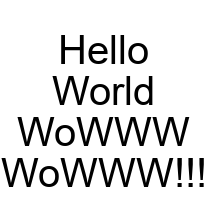

In [27]:
# from PIL import Image, ImageDraw, ImageFont
# import math

# text = "Hello\nWorld\nWoWWW\nWoWWW!!!"
# font_size = 40
# fnt = ImageFont.truetype("arial.ttf", font_size)
# image_size = (224, 224)
# biggest_word = sorted(text.split('\n'), key = lambda x: len(x))[-1]
# max_width = ImageDraw.Draw(Image.new("RGB", (100, 100), (255, 0, 0))).textlength(biggest_word, font=fnt)
# image_size = (math.ceil(max_width), 224)
# out = Image.new("RGB", image_size, (255, 255, 255))
# d = ImageDraw.Draw(out)
# d.multiline_text((image_size[0]/2, image_size[1]/2), text, font=fnt, fill=(0, 0, 0), align ="center", anchor="mm")

# out.show()

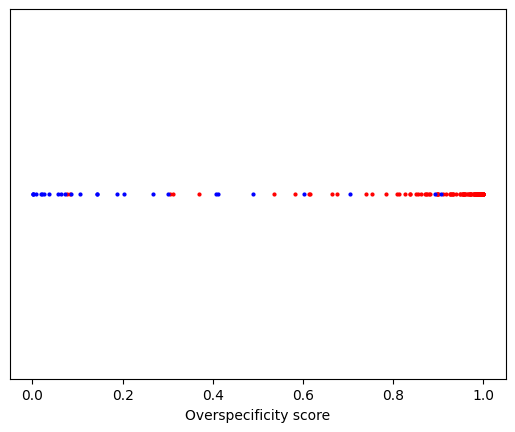

In [18]:
import matplotlib.pyplot as plt

# Example list of tuples
data = overspecificity_score_and_proto_mask

# Separate the data based on the second value
x_0 = [x for x, y, z in data if z == 0]  # First values where the second value is 0
x_1 = [x for x, y, z in data if z == 1]  # First values where the second value is 1

# Create a dummy y-axis value since this is a one-dimensional scatter plot
# y_0 = [y for x, y, z in data if z == 0]  # Dummy y values for blue points
# y_1 = [y for x, y, z in data if z == 1]  # Dummy y values for red points

# y_0 = [1]*len(x_0)
# y_1 = [1.5]*len(x_1)

y_0 = [1]*len(x_0)
y_1 = [1]*len(x_1)

# Plot the data
plt.scatter(x_1, y_1, color='red', label='Value 1', s=4)   # Plot points with second value 1 in red
plt.scatter(x_0, y_0, color='blue', label='Value 0', s=4)  # Plot points with second value 0 in blue


# Additional plot formatting
plt.xlabel('Overspecificity score')
# plt.ylabel('Num descendants')  # Hide y-axis ticks since it's a one-dimensional plot
plt.yticks([])
# plt.legend(loc='best')
# plt.title('One-dimensional Scatter Plot')
plt.show()


In [15]:
!pip show cairosvg